<a href="https://colab.research.google.com/github/edusporto/mac0417/blob/main/EP2_1_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EP2.1 de MAC0417 - Data Augmentation

## Grupo:

Julia Olsson Rego - 10689460

Eduardo Sandalo Porto - 11796510

Elias Kento Tomiyama - 3182204

## Google Drive:

https://drive.google.com/drive/folders/1k6pL_HN4VXwsiBSiIXk0jskFAfDcKR5-?usp=sharing

## Repositório:

https://github.com/edusporto/mac0417


## Observação:

Uma versão compactada do dataset usada no EP1 foi criada para realizar as operações do EP2 de forma mais rápida com arquivos que ocupam menos espaço.

O dataset usado neste EP pode ser encontrado [aqui](https://drive.google.com/drive/folders/1LS01UG2xIzBhn8iYDc7qvdcGr0f9hsyu?usp=sharing), ou na pasta **BancoImagensMin** disponível no Drive compartilhado do grupo. As imagens novas têm resolução 960x1280.

Os dados novos foram gerados usando o ImageMagick, com o comando:

```
find BancoImagensMin -iname '*.jpg' -exec convert \{} -verbose -auto-orient -resize 960x1280\> \{} \;
```

Note que este comando sobrescreve arquivos no diretório em que é executado (BancoDadosMin).

## Setup

In [ ]:
import os
import random
import skimage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from tqdm.notebook import tqdm
from skimage import io 
from skimage.color import rgb2gray
from skimage import img_as_ubyte

In [ ]:
# Usar as imagens armazenadas no Google Drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MAC0417')

Mounted at /content/drive


In [ ]:
# Ler dataset dos metadados
data = pd.read_csv('metadados.csv')
data = data.sort_values(by=['Fundo','Local','Iluminacao','Classe']) # Organizar dataset
data = data.reset_index(drop=True)

In [ ]:
# Ler banco de imagens
dataset_f = 'BancoImagensMin'
imgs_f = [f"{dataset_f}/{img_f}" for img_f in data["Nome do arquivo"]]

In [ ]:
# Seleciona imagens aleatórias

SEED = 324 # semente geradora de números aleatórios

imgs_f_random = imgs_f[:]
random.Random(SEED).shuffle(imgs_f_random)

In [ ]:
def extract_file_name(file_name):
    """
    Com um input `pasta/arquivo.ext`, retorna uma string `arquivo`.
    Usado para extrair o nome dos arquivos do dataset e salvá-los em
    outra pasta.
    """
    return file_name.split("/")[1].split(".")[0]

## Data Augmentation

O propósito desta parte do EP é executar algumas alterações ao nosso dataset original, de forma a construir mais dados com uma gama maior de características. Isso permitirá criar um modelo de predição mais robusto no próximo EP da disciplina.

O enunciado pede as seguintes funções de *data augmentation*:

1. Conversão para níveis de cinza
  - Como pedido no enunciado do EP, todas as funções de *data augmentation* serão aplicadas a imagens em níveis de cinza.

2. Soma de fundo com gradiente de níveis de cinza

3. Logaritmo da imagem

4. Exponencial da imagem

5. Filtro da média implementado usando convolução

As imagens novas serão salvas na pasta `augmentedDataset`.

In [ ]:
new_dataset_f = 'augmentedDataset'

### 1. Conversão para níveis de cinza

O objetivo desta transformação é criar novas imagens sem cores, apenas com níveis de cinza.

Para esta transformação, usaremos a função `rgb2gray` disponibilizada pelo pacote `skimage`.

Vamos primeiro verificar o resultado desta função em alguns exemplos de nosso dataset.

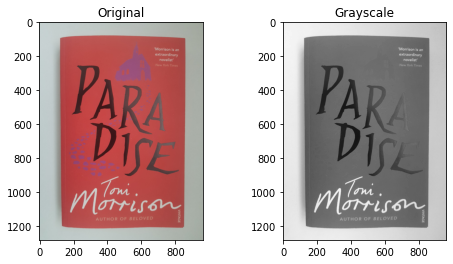

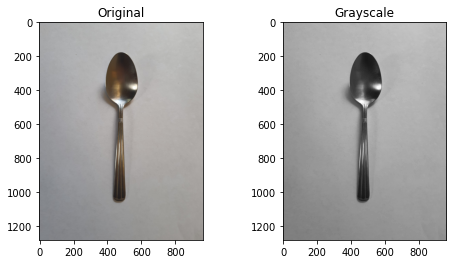

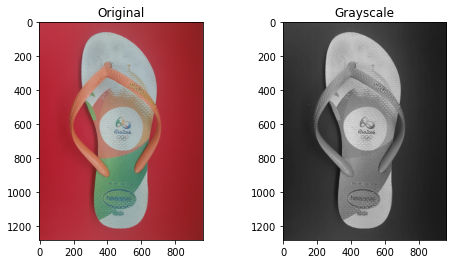

In [ ]:
from skimage.color import rgb2gray

# Seleciona imagens aleatórias (usando a semente SEED) para a análise
for i in range(4, 7):
    random_image_f = imgs_f_random[i]
    random_image = io.imread(random_image_f)

    original = random_image
    grayscale = rgb2gray(random_image)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()

    ax[0].imshow(original)
    ax[0].set_title("Original")
    ax[1].imshow(grayscale, cmap=plt.cm.gray)
    ax[1].set_title("Grayscale")

    plt.show()

Podemos ver, através destas imagens, que o método está executando as operações desejadas.

Vamos então transformar todas as imagens do dataset e salvá-las na pasta `augmentedDataset`. As imagens deste processamento serão identificadas com o marcador `-gray` nos nomes dos arquivos.

Uma vez que as outras funções de *data augmentation* também utilizarão as imagens em níveis de cinza, vamos salvar as imagens calculadas aqui.

O enunciado da parte 2 do EP2 menciona uma pasta `originalGrayDataset`, que não é mencionada nesta parte. Para evitar problemas, vamos salvar as imagens em cinza nesta pasta também.

In [ ]:
operation = 'gray'

imgs_gray = []

for img_f in tqdm(imgs_f):
  img = io.imread(img_f)

  img_grayscale = rgb2gray(img)

  # Necessário para evitar warnings de operação lossy
  img_grayscale_ubyte = img_as_ubyte(img_grayscale)

  # Guardamos as imagens em níveis de cinza para evitar ter que
  # carregá-las do disco novamente depois, uma operação custosa no Google Drive
  imgs_gray.append((img_f, img_grayscale_ubyte))

  new_img_f1 = f"{new_dataset_f}/{extract_file_name(img_f)}-{operation}.jpg"
  new_img_f2 = f"originalGrayDataset/{extract_file_name(img_f)}-{operation}.jpg"
  skimage.io.imsave(new_img_f1, img_grayscale_ubyte)
  skimage.io.imsave(new_img_f2, img_grayscale_ubyte)

Vamos embaralhar as fotos em tons de cinza.

In [ ]:
random.Random(SEED).shuffle(imgs_gray)

## 2. Soma de fundo com gradiente de níveis de cinza

O objetivo desta transformação é adicionar um gradiente de níveis de cinza às imagens do dataset, criando um efeito de luminosidade não constante através da imagem.

Vamos criar nossa própria função para esta etapa.

Primeiro, precisamos gerar gradientes:

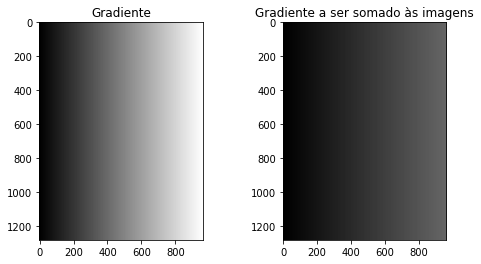

In [ ]:
def gradient(width, height, min, max):
  """
  Gera um gradiente de níveis de cinza para os três canais (RGB)
  """
  values = np.linspace(min, max, width)

  # Adiciona a dimensão 2
  img = np.tile(values, (height, 1))
  # Adiciona a dimensão 3
  # img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
  # Não é necessário adicionar a dimensão 3 (canais de cores),
  # já que as funções de data augmentation serão executadas
  # sobre imagens em níveis de cinza.
  
  # Transforma os pixels para bytes
  img = (255 * img).astype('uint8')

  return img

min_gradient = 0.0
max_gradient = 0.4

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

# Gradiente completo
ax[0].imshow(
    gradient(960, 1280, 0.0, 1.0),
    cmap='gray'
)
ax[0].set_title("Gradiente")

# Gradiente que será somado às imagens
ax[1].imshow(
    gradient(960, 1280, min_gradient, max_gradient),
    cmap='gray',
    vmin=0,
    vmax=255)
ax[1].set_title("Gradiente a ser somado às imagens")

plt.show()

A função acima é capaz de gerar imagens de gradiente. Estas terão seus pixels somados aos pixels das imagens que queremos transformar. Caso usássemos pixels para o gradiente com valores de 0 a 1 (suponto sistema de pixels float), haveria muita saturação.

Vamos ver alguns exemplos de imagens com gradientes somados:

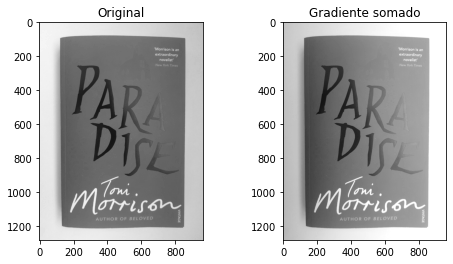

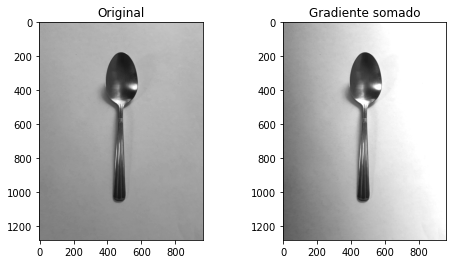

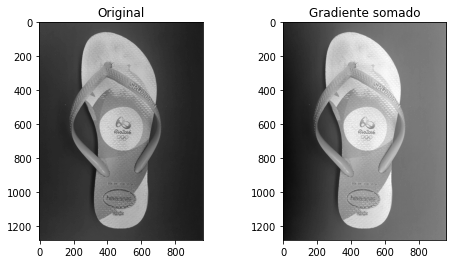

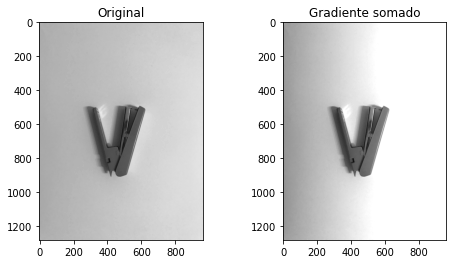

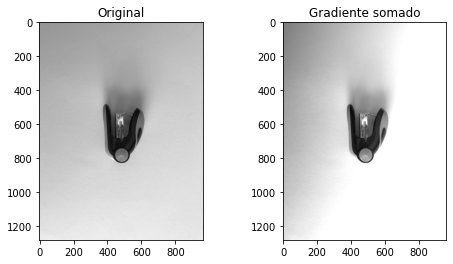

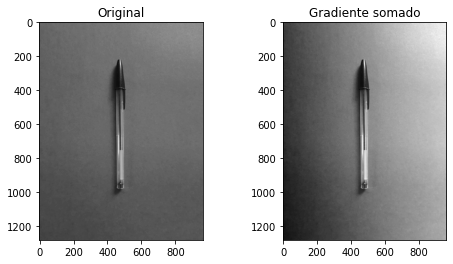

In [ ]:
def add_images(img1, img2):
  # Quando somando imagens, corremos risco de ter overflow na soma
  # de pixels. Para isso, vamos fazer a soma com pixels de 32 bits por canal,
  # corrigir as saturações e devolver o vetor com 8 bits por canal.
  img1_32 = img1.astype('uint32')
  img2_32 = img2.astype('uint32')

  new = img1_32 + img2_32
  new = np.where(new > 255, 255, new) # corrige overflow
  return new.astype('uint8')

def add_gradient(img, min, max):
  return add_images(
    img,
    gradient(img.shape[1], img.shape[0], min, max)
  )

# Seleciona imagens aleatórias em tons de cinza
# (usando a semente SEED) para a análise
for i in range(4, 10):
    random_image_f, random_image = imgs_gray[i]

    original = random_image
    new_img = add_gradient(original, min_gradient, max_gradient)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()

    ax[0].imshow(original, cmap='gray')
    ax[0].set_title("Original")
    ax[1].imshow(new_img, cmap=plt.cm.gray)
    ax[1].set_title("Gradiente somado")

    plt.show()

Podemos ver que o método está chegando a resultados corretos.

Note que em imagens que já são bem claras, há bastante saturação. Uma possível diferença de metodologia para diminuir a saturação seria alterar os valores do gradiente para serem de -127 as +127, e então somá-lo à imagem original. Isso permitira escurecer e clarear as imagens, e não apenas clareá-las como o método atual.

O enunciado do EP não entra em detalhes se essa mudança é permitida. Portanto, manteremos a técnica atual.

Vamos agora salvar as imagens novas na pasta `augmentedDataset`. As imagens deste processamento serão identificadas com o marcador `-grad` nos nomes dos arquivos.

In [ ]:
operation = 'grad'

# Vamos iterar sobre `imgs_gray`, que contêm as imagens já
# em níveis de cinza.
for img_f, img in tqdm(imgs_gray):
  img = add_gradient(img, min_gradient, max_gradient)

  new_img_f = f"{new_dataset_f}/{extract_file_name(img_f)}-{operation}.jpg"
  skimage.io.imsave(new_img_f, img)

## 3. Logaritmo da imagem

O objetivo desta transformação é alterar os pixels das imagens usando funções logarítmicas. Isto permite corrigir ou alterar o contraste dos pixels na imagem.

Vamos criar a função desta transformação e ver seu resultado em algumas imagens do dataset.

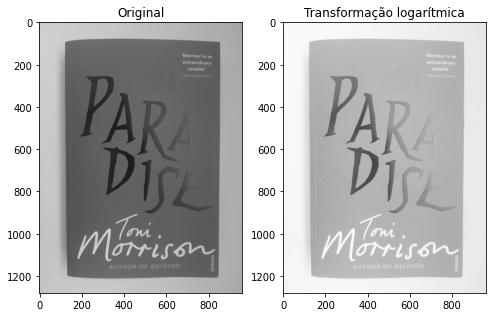

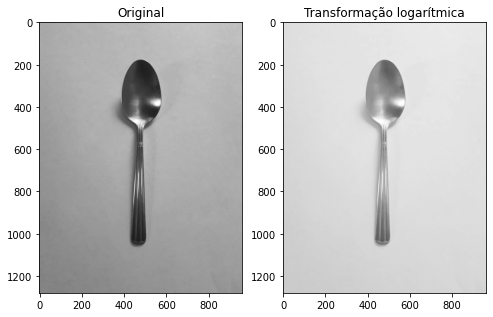

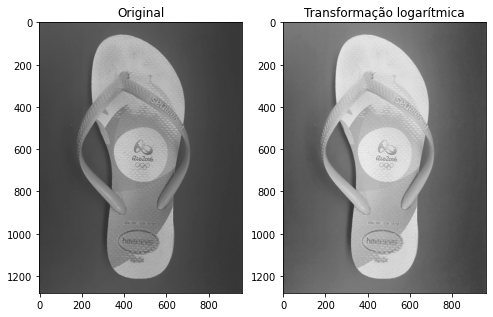

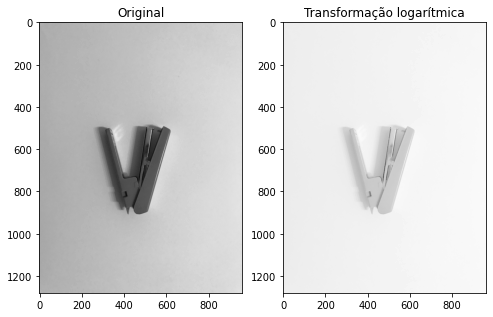

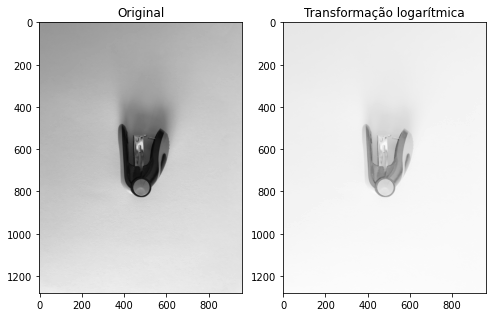

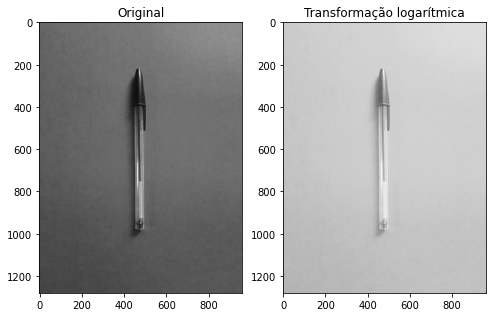

In [ ]:
def log_transform(img):

  img = img.astype('float64') # evitar problemas de overflow

  c = 255 / np.log(1 + np.max(img))
  img = c * (np.log(img + 1))
  img = np.where(img > 255, 255, img) # corrige overflow

  img = img.astype('uint8')

  return img

# Seleciona imagens aleatórias em tons de cinza
# (usando a semente SEED) para a análise
for i in range(4, 10):
    random_image_f, random_image = imgs_gray[i]

    original = random_image
    new_img = log_transform(original)
    #new_img = skimage.exposure.adjust_log(skimage.img_as_float64(original), 1)

    fig, axes = plt.subplots(1, 2, figsize=(8, 8))
    ax = axes.ravel()

    ax[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    ax[0].set_title("Original")
    ax[1].imshow(new_img, cmap='gray')
    ax[1].set_title("Transformação logarítmica")

    plt.show()

Podemos ver que o método está chegando a resultados corretos. Em alguns casos, como o grampeador em uma superfície clara, é possível observar que a função logarítmica tornou a imagem mais difícil de ser compreendida.

Porém, como foi pedido no enunciado do exercício, vamos salvar estas imagens em `augmentedDataset`. As imagens deste processamento serão identificadas com o marcador `-log`.

In [ ]:
operation = 'log'

# Vamos iterar sobre `imgs_gray`, que contêm as imagens já
# em níveis de cinza.
for img_f, img in tqdm(imgs_gray):
  img = log_transform(img)

  new_img_f = f"{new_dataset_f}/{extract_file_name(img_f)}-{operation}.jpg"
  skimage.io.imsave(new_img_f, img)

## 4. Exponencial da imagem

O objetivo desta transformação, assim como a transformação logarítmica, é alterar os pixels das imagens para corrir ou alterar contraste, mas usando funções exponenciais. Enquanto a função logarítmica aumentava contraste entre pontos escuros, a função exponencial aumentará contraste entre pontos claros.

Vamos criar a função desta transformação e ver seu resultado em algumas imagens do dataset.

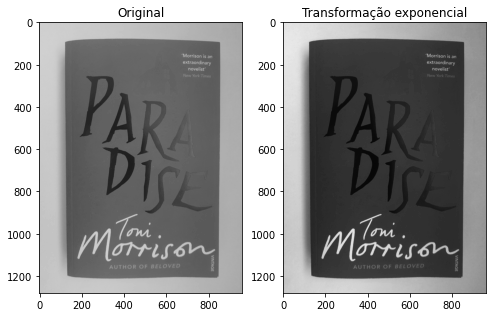

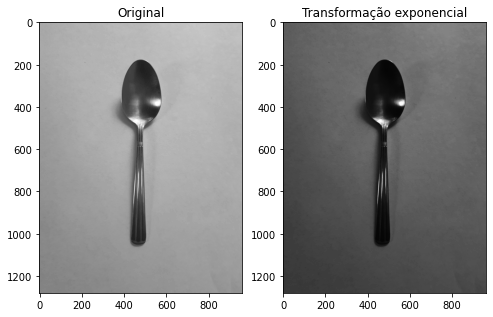

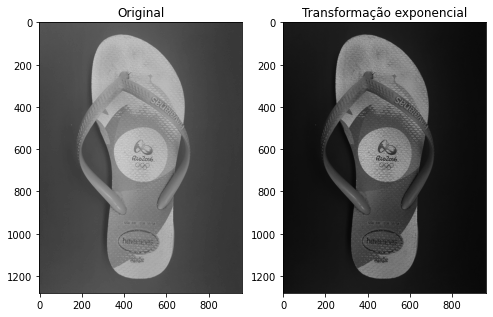

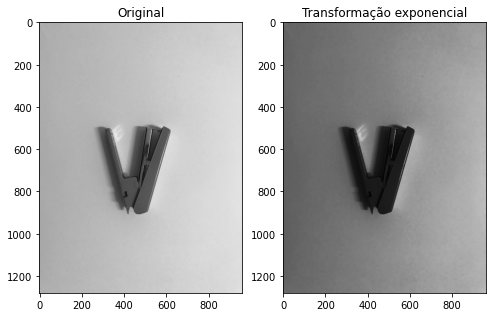

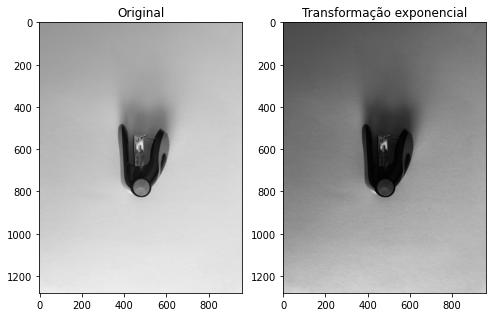

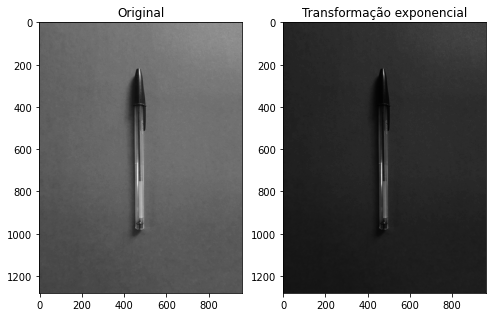

In [ ]:
def exp_transform(img, base):
  img = img.astype('float64') # evitar problemas de overflow

  c = 255 / (base**np.max(img) - 1)
  img = c * (base**img - 1)
  img = np.where(img > 255, 255, img) # corrige overflow

  img = img.astype('uint8')

  return img

base = 1.01 # base para os expoentes da transformação

# Seleciona imagens aleatórias em tons de cinza
# (usando a semente SEED) para a análise
for i in range(4, 10):
    random_image_f, random_image = imgs_gray[i]

    original = random_image
    new_img = exp_transform(original, base)

    fig, axes = plt.subplots(1, 2, figsize=(8, 8))
    ax = axes.ravel()

    ax[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    ax[0].set_title("Original")
    ax[1].imshow(new_img, cmap='gray')
    ax[1].set_title("Transformação exponencial")

    plt.show()

Podemos ver que a função está chegando a resultados corretos. Considerando que a maior parte dos objetos é escura, este método está tirando detalhes visuais dos objetos através da dimunição do contraste.

Vamos salvar os resultados em `augmentedDataset`, com o marcador `-exp`.

In [ ]:
operation = 'exp'

# Vamos iterar sobre `imgs_gray`, que contêm as imagens já
# em níveis de cinza.
for img_f, img in tqdm(imgs_gray):
  img = exp_transform(img, base)

  new_img_f = f"{new_dataset_f}/{extract_file_name(img_f)}-{operation}.jpg"
  skimage.io.imsave(new_img_f, img)

## 5. Filtro da média implementado usando convolução

Agora, queremos calcular usar o filtro da média nas imagens de nosso dataset. Na prática, este filtro borra as imagens.

Vamos criar a função desta transformação e ver seu resultado em algumas imagens do dataset.

Para nossa convolução, usaremos um *kernel* (matriz) de dimensões nxn, cujos valores são todos iguais 1/(n*n). Quando multiplicado com cada pedaço da matriz completa da imagem, isso resultará na média dos valores do pedaço.

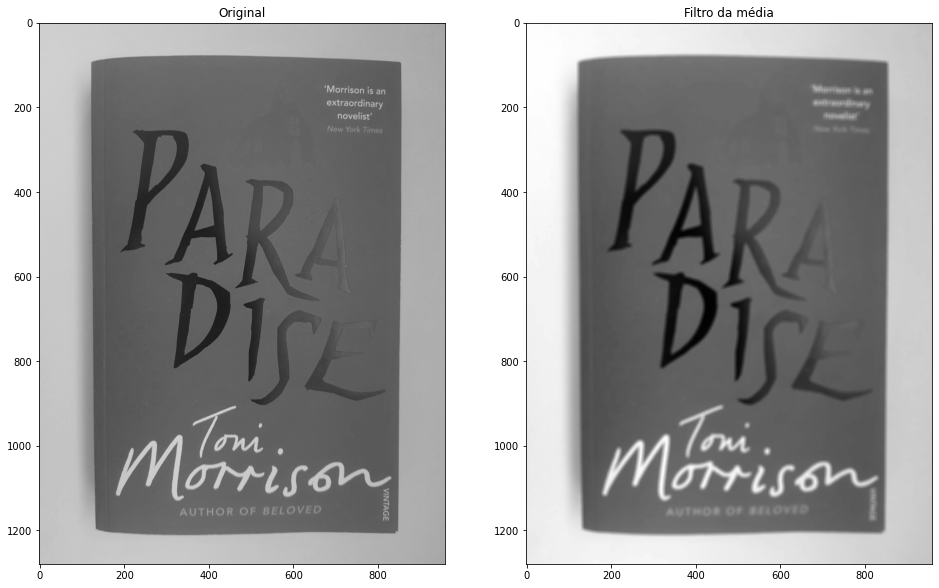

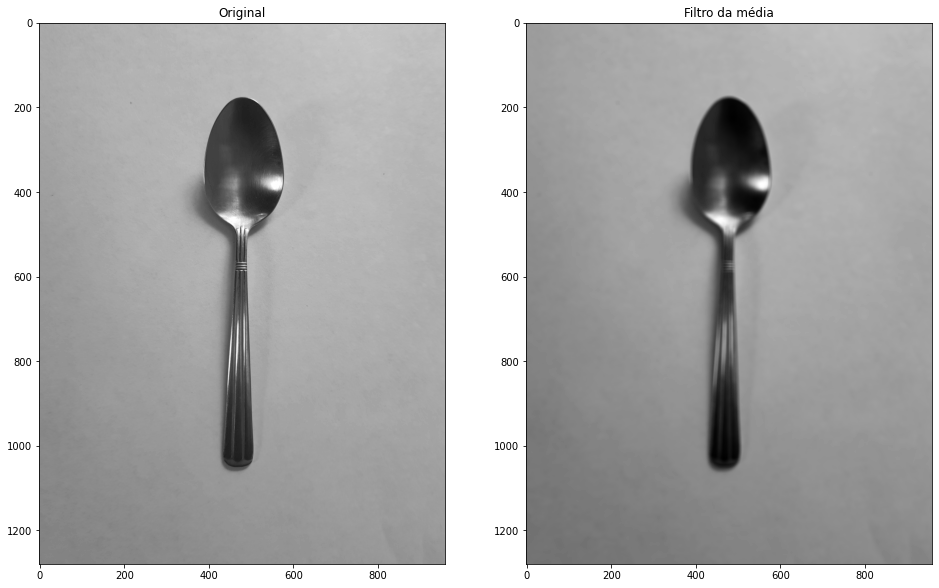

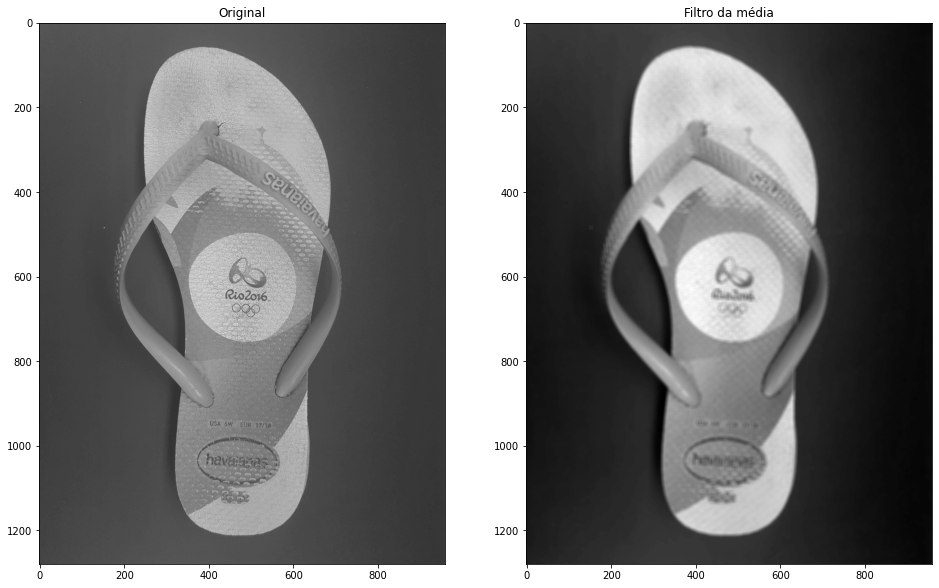

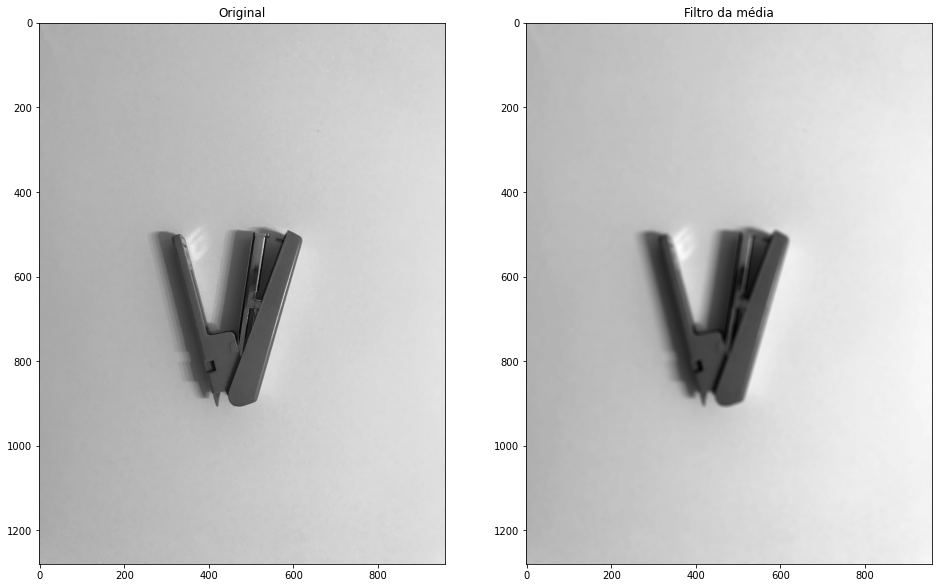

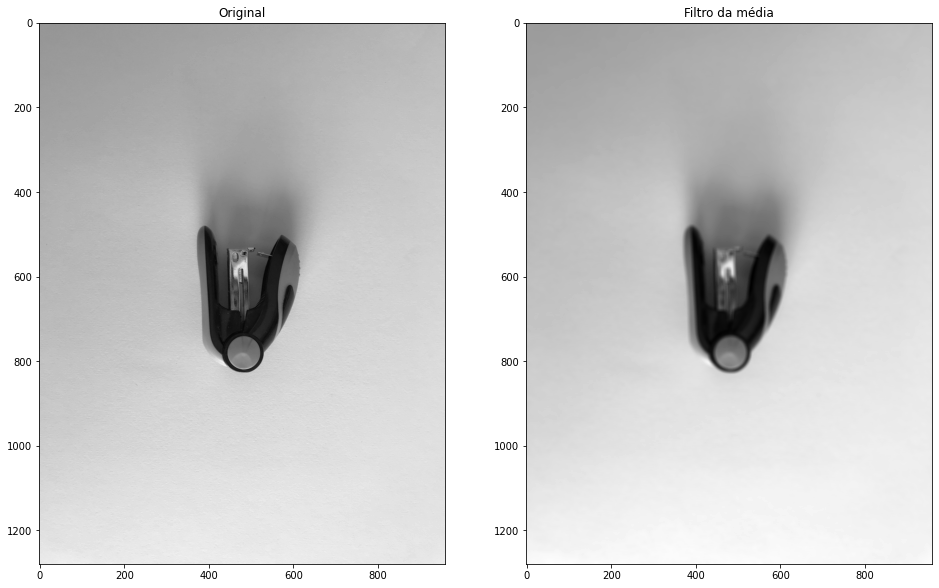

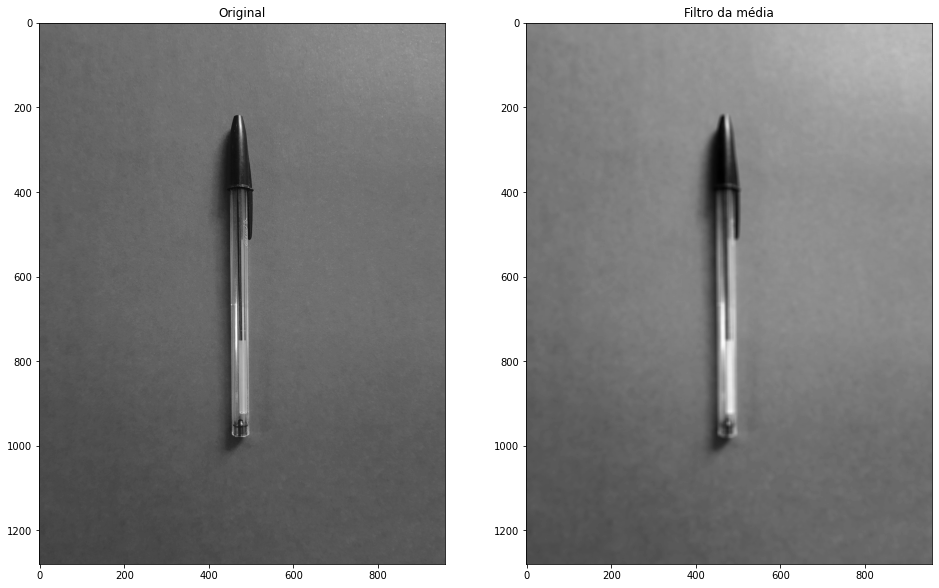

In [ ]:
def mean_filter(img, n):
  from scipy.ndimage.filters import convolve

  # Kernel apenas 3x3:
  # kernel = np.array([[1.0, 1.0, 1.0],
  #                    [1.0, 1.0, 1.0],
  #                    [1.0, 1.0, 1.0]]) / 9.0
  # Kernel nxn:
  kernel = np.ones((n, n)) / (n * n)

  # mode='nearest' irá fazer com que as linhas e
  # colunas faltantes sejam iguais à última linha
  # ou coluna antes de começar a faltar
  img = convolve(img, kernel, mode='nearest')

  return img

n = 10 # Dimensão da matriz da convolução (kernel)

# Seleciona imagens aleatórias em tons de cinza
# (usando a semente SEED) para a análise
for i in range(4, 10):
    random_image_f, random_image = imgs_gray[i]

    original = random_image
    new_img = mean_filter(original, n)

    fig, axes = plt.subplots(1, 2, figsize=(16, 16))
    ax = axes.ravel()

    ax[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    ax[0].set_title("Original")
    ax[1].imshow(new_img, cmap='gray')
    ax[1].set_title("Filtro da média")

    plt.show()

Podemos ver que o método está chegando a resultados corretos. Note que em alguns casos, como no chinelo do exemplo acima, algumas regiões podem ter um escurecimento aparente grande.

Vamos salvar estas imagens em `augmented Dataset`, com o marcador `-mean`.

In [ ]:
operation = 'mean'

# Vamos iterar sobre `imgs_gray`, que contêm as imagens já
# em níveis de cinza.
for img_f, img in tqdm(imgs_gray):
  img = mean_filter(img, n)

  new_img_f = f"{new_dataset_f}/{extract_file_name(img_f)}-{operation}.jpg"
  skimage.io.imsave(new_img_f, img)